In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import cdist

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
movie = '/content/drive/My Drive/dataset/movies_metadata.csv'
movie_df = pd.read_csv(movie)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
movie_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movie_df['overview'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [ ]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

# Create Movie Profile


#### Data Preprocessing

In [ ]:
import re
# drop unwanted columns
movie_df.drop(columns=['adult','budget','homepage','imdb_id','original_language','release_date','poster_path','production_companies','production_countries','release_date','revenue','runtime','spoken_languages','status','title','video','vote_count','popularity','belongs_to_collection', 'vote_average'],inplace=True)
# remove NA values
movie_df = movie_df[movie_df["tagline"].str.contains("NaN") == False]
# 
movie_features = ["genres","overview","tagline"]
# combine these features, cleaning the content of the feature
def combined_features(row):
 return row['genres'] + " " + row['overview'] + " " + row['tagline']
for feature in movie_features:
  movie_df[feature] = movie_df[feature].str.replace(r'[^\w\s]+', '').str.replace(r'[\d]+', '').str.replace('name', '').str.replace('id', '').str.replace(r'[\s]+', ' ').str.lower()
  movie_df[feature] = movie_df[feature].fillna('')
movie_df['combined_features'] = movie_df.apply(combined_features, axis=1)


<ipython-input-7-5c64b004e7aa>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  movie_df[feature] = movie_df[feature].str.replace(r'[^\w\s]+', '').str.replace(r'[\d]+', '').str.replace('name', '').str.replace('id', '').str.replace(r'[\s]+', ' ').str.lower()


In [ ]:
movie_df.shape

(20412, 6)

In [ ]:
movie_df.head()

,genres,id,original_title,overview,tagline,combined_features
1,adventure fantasy family,8844,Jumanji,when siblings judy and peter discover an encha...,roll the dice and unleash the excitement,adventure fantasy family when siblings judy a...
2,romance comedy,15602,Grumpier Old Men,a family wedding reignites the ancient feud be...,still yelling still fighting still ready for love,romance comedy a family wedding reignites the...
3,comedy drama romance,31357,Waiting to Exhale,cheated on mistreated and stepped on the women...,friends are the people who let you be yourself...,comedy drama romance cheated on mistreated an...
4,comedy,11862,Father of the Bride Part II,just when george banks has recovered from his ...,just when his world is back to normal hes in f...,comedy just when george banks has recovered f...
5,action crime drama thriller,949,Heat,obsessive master thief neil mccauley leads a t...,a los angeles crime saga,action crime drama thriller obsessive master ...


In [ ]:
movie_df['combined_features'] = movie_df['combined_features'].str.strip()
movie_df['combined_features'] = movie_df['combined_features'].fillna("").astype('str')

movie_df.head()

,genres,id,original_title,overview,tagline,combined_features
1,adventure fantasy family,8844,Jumanji,when siblings judy and peter discover an encha...,roll the dice and unleash the excitement,adventure fantasy family when siblings judy an...
2,romance comedy,15602,Grumpier Old Men,a family wedding reignites the ancient feud be...,still yelling still fighting still ready for love,romance comedy a family wedding reignites the ...
3,comedy drama romance,31357,Waiting to Exhale,cheated on mistreated and stepped on the women...,friends are the people who let you be yourself...,comedy drama romance cheated on mistreated and...
4,comedy,11862,Father of the Bride Part II,just when george banks has recovered from his ...,just when his world is back to normal hes in f...,comedy just when george banks has recovered fr...
5,action crime drama thriller,949,Heat,obsessive master thief neil mccauley leads a t...,a los angeles crime saga,action crime drama thriller obsessive master t...


In [ ]:
movie_df["combined_features"]

1        adventure fantasy family when siblings judy an...
2        romance comedy a family wedding reignites the ...
3        comedy drama romance cheated on mistreated and...
4        comedy just when george banks has recovered fr...
5        action crime drama thriller obsessive master t...
                               ...                        
45454    comedy drama the morning after is a feature fi...
45456    horror mystery thriller an unsuccessful sculpt...
45458    horror a film archivist revisits the story of ...
45461    drama family rising and falling between a man ...
45463    action drama thriller when one of her hits goe...
Name: combined_features, Length: 20412, dtype: object

#### Convert to TF-IDF

In [ ]:
# prepare stopwords
with open('/content/drive/My Drive/dataset/stopwords-english') as f:
    stopwords = f.read().splitlines()

print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(stop_words= 'english')
tfidf = tf.fit_transform(movie_df['combined_features'])
tfidf.shape

(20412, 55326)

#### Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine = cosine_similarity(tfidf, tfidf)
cosine[:6, :6]

array([[1.        , 0.02838648, 0.        , 0.0071404 , 0.03882822,
        0.        ],
       [0.02838648, 1.        , 0.00736541, 0.0414469 , 0.        ,
        0.00895673],
       [0.        , 0.00736541, 1.        , 0.00356674, 0.00798271,
        0.0096928 ],
       [0.0071404 , 0.0414469 , 0.00356674, 1.        , 0.        ,
        0.02650001],
       [0.03882822, 0.        , 0.00798271, 0.        , 1.        ,
        0.        ],
       [0.        , 0.00895673, 0.0096928 , 0.02650001, 0.        ,
        1.        ]])

#### Euclidean_distance

In [ ]:
Euclidean = 1 - pairwise_distances(tfidf, metric = "euclidean")
Euclidean

array([[ 1.        , -0.39399679, -0.41421356, ..., -0.40783441,
        -0.40735   , -0.36609216],
       [-0.39399679,  1.        , -0.40899581, ..., -0.41421356,
        -0.40731707, -0.41421356],
       [-0.41421356, -0.40899581,  1.        , ..., -0.41421356,
        -0.39470982, -0.41173665],
       ...,
       [-0.40783441, -0.41421356, -0.41421356, ...,  1.        ,
        -0.41421356, -0.41421356],
       [-0.40735   , -0.40731707, -0.39470982, ..., -0.41421356,
         1.        , -0.40954151],
       [-0.36609216, -0.41421356, -0.41173665, ..., -0.41421356,
        -0.40954151,  1.        ]])

In [ ]:
titles = movie_df['original_title']
indices = pd.Series(movie_df.reset_index().index, index=movie_df['original_title'])
indices

original_title
Jumanji                            0
Grumpier Old Men                   1
Waiting to Exhale                  2
Father of the Bride Part II        3
Heat                               4
                               ...  
The Morning After              20407
House of Horrors               20408
The Burkittsville 7            20409
رگ خواب                        20410
Betrayal                       20411
Length: 20412, dtype: int64

Chebyshev and Jaccard
 

#### Implementation and Results

In [ ]:
def Cosine_recommendations(movie_title, sim = cosine):
    movie_id = indices[movie_title]
    global sim_scores
    sim_scores = list(enumerate(sim[movie_id]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return movie_df['original_title'].iloc[movie_indices]

In [ ]:
Cosine_recommendations("John Wick")

42168    John Wick: Chapter 2
3534                    Lured
12104         The Dog Problem
4445               Blind Fury
23859                 The Dog
807                 Stonewall
29577           Welcome to Me
23238               Wake Wood
41814         A Dog's Purpose
10198            C.H.O.M.P.S.
Name: original_title, dtype: object

In [ ]:
Cosine_recommendations("The Dark Knight")

18252                      The Dark Knight Rises
1328                              Batman Returns
20232    Batman: The Dark Knight Returns, Part 2
15511                 Batman: Under the Red Hood
25267                          Batman vs Dracula
22021                             The Super Cops
19792    Batman: The Dark Knight Returns, Part 1
39626                   Batman: The Killing Joke
18035                           Batman: Year One
10122                              Batman Begins
Name: original_title, dtype: object

In [ ]:
Cosine_recommendations("Shutter Island")


41782         City of Dead Men
26269            On the Inside
20026             The Incident
12717       The Rape of Europa
42019                    रंगून
5486             Crazy As Hell
37929                   Rumble
16809         Closing the Ring
8422     The Mask of Dimitrios
18707           La cara oculta
Name: original_title, dtype: object

In [ ]:
Cosine_recommendations("Braveheart")


1181                    Henry V
14834                      1066
6246         A Man Called Horse
21971            How I Live Now
6900           Mary of Scotland
7996                  Guerreros
26489              Oliver Twist
30049             The Lookalike
31107              Morning Star
8587     La battaglia di Algeri
Name: original_title, dtype: object

In [ ]:
Cosine_recommendations("La La Land")

37703    Born to Be Blue
25221      Hey Bartender
33618       Dirty O'Neil
10840      She's the Man
39550            Пятница
23962          If I Stay
18084          Bandwagon
9180             Im Juli
41688               Sing
14813          Fish Tank
Name: original_title, dtype: object

In [ ]:
Cosine_recommendations("Harry Potter and the Philosopher's Stone")

5678          Harry Potter and the Chamber of Secrets
4370                                    The Dead Pool
10554             Harry Potter and the Goblet of Fire
23506                                             Luv
7725         Harry Potter and the Prisoner of Azkaban
11927       Harry Potter and the Order of the Phoenix
39065                               Bullet to Beijing
18825                                Wild About Harry
3951              Harry, un ami qui vous veut du bien
17437    Harry Potter and the Deathly Hallows: Part 2
Name: original_title, dtype: object

In [ ]:
Cosine_recommendations("Intouchables")

21911                   Arthur Newman
9720                         Paha Maa
25038               The Heart Machine
31025    The Dive from Clausen's Pier
11121                           Scoop
35110                   The Big Short
17239                  Lottery Ticket
17432                     Monte Carlo
12994                     The Duchess
21435                            Jobs
Name: original_title, dtype: object

In [ ]:
Cosine_recommendations("TRON: Legacy")

1996                                              Tron
8394                                      The Sea Hawk
13886    The Librarian: The Curse of the Judas Chalice
11877                                       Dodge City
9031                                   Josh and S.A.M.
7638                                     Captain Blood
11925                                     Transformers
18202                                             Xtro
2587                                     Summer of Sam
11157                                       Johnny Was
Name: original_title, dtype: object

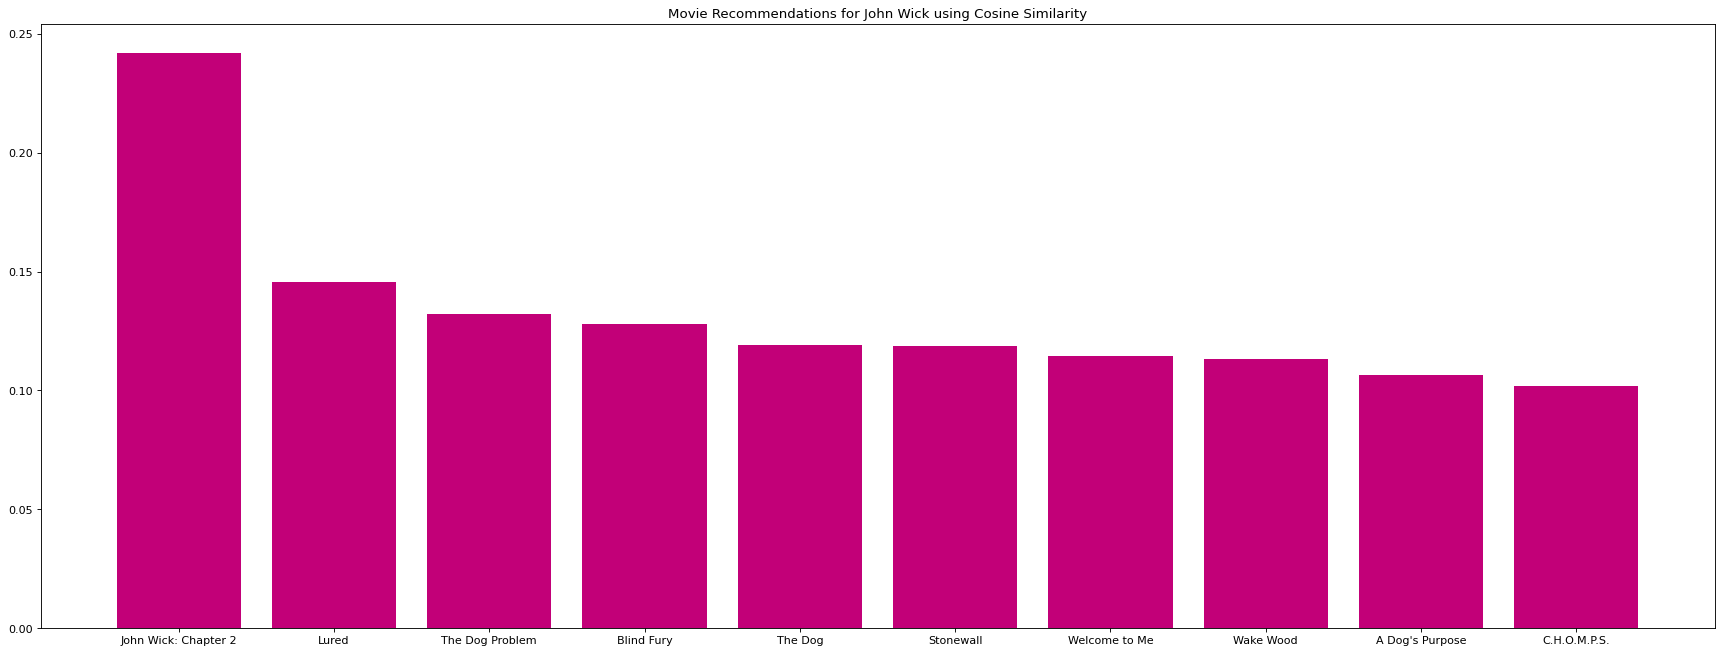

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(27, 10), dpi=80)
movie_indices = [i[0] for i in sim_scores]
raw_score = []
for element in sim_scores:
  raw_score.append(element[1])


x = np.array(movie_df['original_title'].iloc[movie_indices])
y = np.array(raw_score)


plt.bar(x,y,color = "#C20078")
plt.title("Movie Recommendations for John Wick using Cosine Similarity")
plt.show()

In [ ]:
def Euclidean_recommendations(movie_title, sim = Euclidean):
    movie_id = indices[movie_title]
    global sim_scores
    sim_scores = list(enumerate(sim[movie_id]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return movie_df['original_title'].iloc[movie_indices]

In [ ]:
Euclidean_recommendations("John Wick")

42168    John Wick: Chapter 2
3534                    Lured
12104         The Dog Problem
4445               Blind Fury
23859                 The Dog
807                 Stonewall
29577           Welcome to Me
23238               Wake Wood
41814         A Dog's Purpose
10198            C.H.O.M.P.S.
Name: original_title, dtype: object

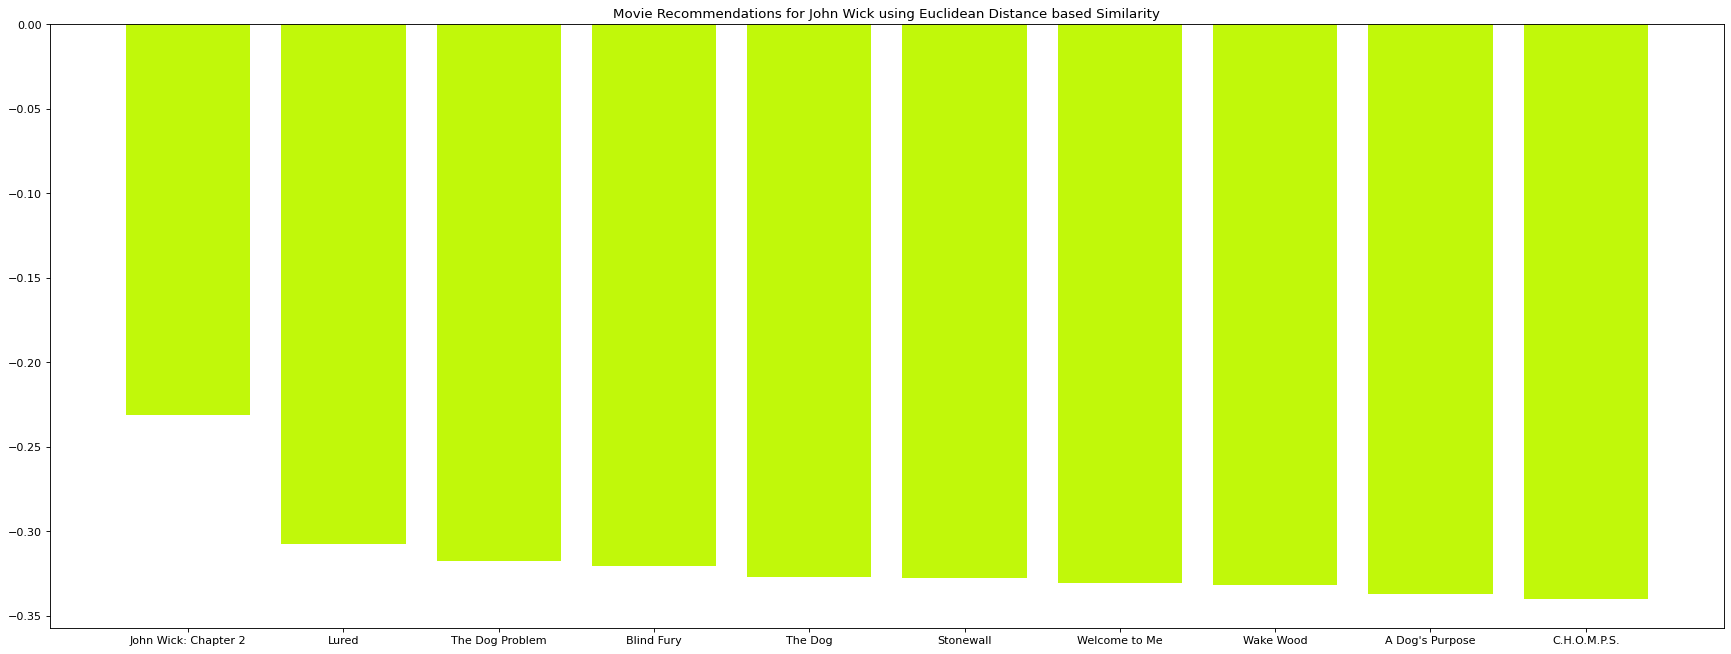

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(27, 10), dpi=80)
movie_indices = [i[0] for i in sim_scores]
raw_score = []
for element in sim_scores:
  raw_score.append(element[1])


x = np.array(movie_df['original_title'].iloc[movie_indices])
y = np.array(raw_score)


plt.bar(x,y, color = "#C1F80A")
plt.title("Movie Recommendations for John Wick using Euclidean Distance based Similarity")
plt.show()